# Ornstein-Uhlenbeck Process: Properties and Estimation

<center> Author: Faisal Jayousi </center>

<center> Date: January 2025   </center>

The Ornstein–Uhlenbeck process was introduced by Ornstein and Uhlenbeck in 1930 as a model for the velocity of a Brownian particle. In financial mathematics, it is often referred to as the Vasicek model, particularly in the context of interest rate modeling.

It is a mean-reverting stochastic differential equation of the form: $$dX_t = \theta(\mu-X_t)dt+\sigma dB_t$$ where $\mu\in\mathbb{R}$ is the long-term mean, $\theta\in\mathbb{R}_+^*$ is the speed of mean-reversion, $\sigma\in\mathbb{R}_+^*$ is the volatility, and $(B_t)_{t}$ is the standard Brownian motion. In integral form, the process is expressed as $$X_t = X_0 + \theta\mu t - \theta\int_0^tX_sds+\sigma B_t$$

## Table of Contents

- [Ornstein-Uhlenbeck Process: Properties and Estimation](#ornstein-uhlenbeck-process:-properties-and-estimation)
  - [Key properties](#key-properties)
  - [Simulating and Visualising the Process](#simulating-and-visualising-the-process)
  - [Statistical Inference: Extracting Parameters from Data](#statistical-inference:-extracting-parameters-from-data)
    - [Inference from Multiple Paths at a Fixed Time](#inference-from-multiple-paths-at-a-fixed-time)
    - [Single Path Estimation: Learning from One Realisation](#single-path-estimation:-learning-from-one-realisation)
      - [Least Squares Estimation](#least-squares-estimation)
      - [Maximum Likelihood Estimation](#maximum-likelihood-estimation)


## Key properties

1. Larger values for $\theta$ will cause the process to mean-revert more rapidly.
2. The parameter $\mu$ represents the long-term mean of the process. The drift term $\theta(\mu-X_t)$ ensures mean-reversion: when $X_t<\mu$ the drift is positive, driving the process upward toward $\mu$, and vice versa, when $X_t>\mu$ the drift is negative, pulling the process downward toward $\mu$.
3. The Ornstein-Uhlenbeck SDE admits the following closed form solution $$X_t = X_0e^{-\theta t}+\mu(1-e^{-\theta t})+\sigma\int_0^t e^{-\theta(t-s)}dB_s$$
4. As $t\to+\infty$, the process converges to a Gaussian distribution: $$\mathcal{L}\left(\lim_{t\to+\infty}X_t\right)=\mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$$
5. Its infinitesimal generator is given by $(\mathcal{Q}f)(x)=-\theta(x-\mu)f^\prime(x)+\frac{1}{2\sigma^2}f^{\prime\prime}(x)$.


In [1]:
# Import libraries
import numpy as np
import scipy.stats as ss

from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

## Simulating and Visualising the Process


In [2]:
def generate_ou_paths(
    initial_value,
    num_paths,
    mean_reversion_speed=3.0,
    long_term_mean=0.5,
    volatility=0.5,
    time_horizon=5.0,
    num_time_steps=20000,
    *,
    seed=None,
):
    """
    Generate paths for the Ornstein-Uhlenbeck process.

    Parameters:
        initial_value (float): Initial value of the process (X0).
        num_paths (int): Number of paths to simulate.
        mean_reversion_speed (float): Speed of mean reversion (kappa).
        long_term_mean (float): Long-term mean (theta).
        volatility (float): Volatility (sigma).
        time_horizon (float): Total time horizon (T).
        num_time_steps (int): Number of time steps.

    Returns:
        np.ndarray: Simulated paths of shape (num_time_steps, num_paths).
    """
    np.random.seed(seed)

    # Time vector and step size
    time_vector, dt = np.linspace(
        0, time_horizon, num_time_steps, retstep=True)

    # Initialise array
    paths = np.zeros((num_time_steps, num_paths))
    paths[0, :] = initial_value

    # Generate random Brownian increments
    brownian_increments = ss.norm.rvs(
        loc=0, scale=1, size=(num_time_steps - 1, num_paths))

    # Simulate paths using Euler-Maruyama's method
    for t in range(num_time_steps - 1):
        paths[t + 1, :] = (
            paths[t, :]
            + mean_reversion_speed * (long_term_mean - paths[t, :]) * dt
            + volatility * np.sqrt(dt) * brownian_increments[t, :]
        )

    return paths, time_vector

In [3]:
# Define parameters in a dictionary for clarity
params = {
    "X0": 2,                  # Initial value
    "theta": 3,               # Mean reversion speed
    "mu": 0.5,                # Long-term mean
    "sigma": 0.5,             # Volatility
    "N": 20_000,              # Time steps
    "num_paths": 5_000,       # Number of simulated paths
    "T": 5                    # Time horizon
}

# Generate Ornstein-Uhlenbeck paths
X, time_vector = generate_ou_paths(
    initial_value=params["X0"],
    num_paths=params["num_paths"],
    mean_reversion_speed=params["theta"],
    long_term_mean=params["mu"],
    volatility=params["sigma"],
    time_horizon=params["T"],
    seed=321
)

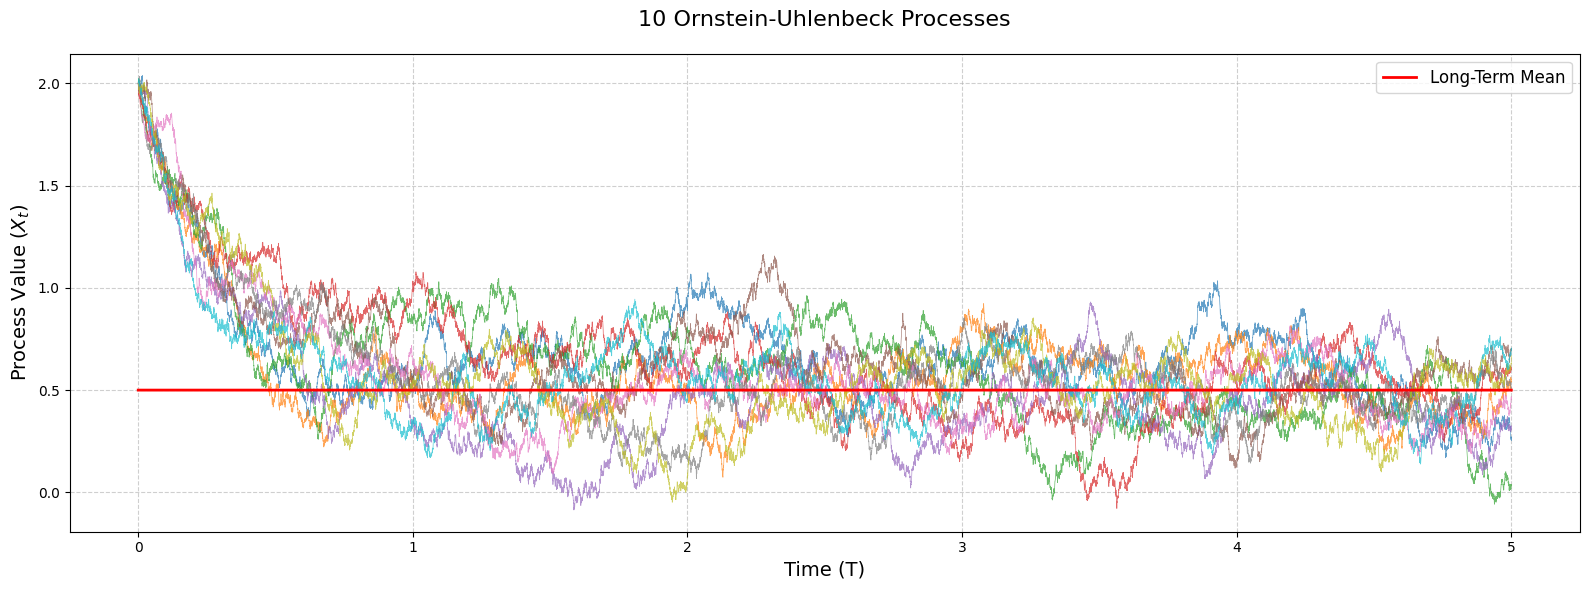

In [4]:
N_processes = 10

plt.figure(figsize=(16, 6))

# Plot simulated OU paths and long-term mean
plt.plot(time_vector, X[:, :N_processes], linewidth=0.5, alpha=0.7)
plt.plot(time_vector, params["mu"] * np.ones_like(time_vector),
         label="Long-Term Mean", color="red", linestyle="-", linewidth=2)

plt.title(f"{N_processes} Ornstein-Uhlenbeck Processes", fontsize=16, pad=20)
plt.xlabel("Time (T)", fontsize=14)
plt.ylabel("Process Value ($X_t$)", fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## Statistical Inference: Extracting Parameters from Data


### Inference from Multiple Paths at a Fixed Time

Given $N$ realisations of an Ornstein-Uhlenbeck (OU) process, we can estimate the mean and variance of the process at any fixed time $t\in[0, T]$. The theoretical mean and covariance of the OU process are given by:

$$
\mathbb{E}[X_t] = \mu + (X_0 - \mu) e^{-\theta t},
$$

$$
\operatorname{Cov}(X_t, X_s) = \frac{\sigma^2}{2\theta} \left( e^{-\theta|t-s|} - e^{-\theta(t+s)} \right).
$$

**Corollary** The Ornstein-Uhlenbeck process has exponentially decaying autocorrelation: $$\rho(X_t,X_{t+\tau})=e^{-\theta\tau}$$

These expressions allow us to compare empirical estimates with the theoretical properties of the process.


Theoretical mean: 0.5000, Theoretical standard deviation: 0.2041
Empirical mean: 0.5100, Empirical standard deviation: 0.2055


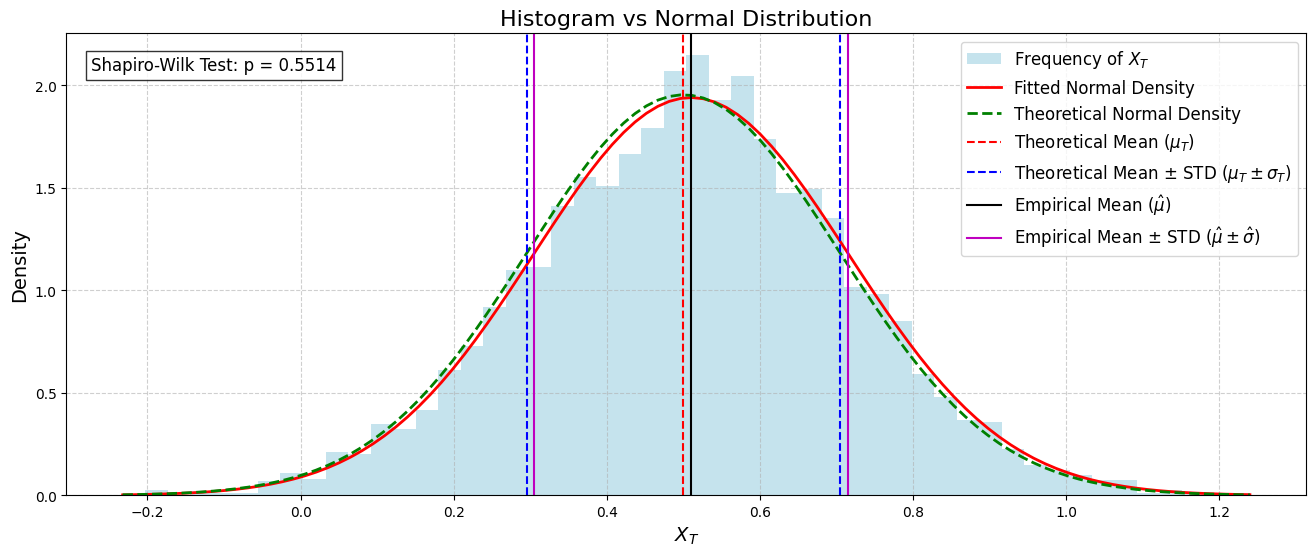

In [5]:
X_T = X[-1, :]  # values of X at time T

# Theoretical mean and std
mean_T = params["mu"] + np.exp(-params["theta"]
                               * params["T"]) * (params["X0"] - params["mu"])
std_T = np.sqrt(params["sigma"]**2 / (2 * params["theta"])
                * (1 - np.exp(-2 * params["theta"] * params["T"])))

# Estimated mean and std
mean_hat, std_hat = X_T.mean(), X_T.std()  # MLE estimators

print(f"Theoretical mean: {
      mean_T:.4f}, Theoretical standard deviation: {std_T:.4f}")
print(f"Empirical mean: {
      mean_hat:.4f}, Empirical standard deviation: {std_hat:.4f}")


# Generate data for the fitted normal PDF
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, mean_hat, std_hat)  # Fitted normal PDF
pdf_theoretical = ss.norm.pdf(x, mean_T, std_T)  # Theoretical normal PDF

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = shapiro(X_T)

# Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.hist(X_T, density=True, bins=50, color="lightblue",
        alpha=0.7, label="Frequency of $X_T$")

# Plot fitted and theoretical normal distributions
ax.plot(x, pdf_fitted, color="red", lw=2, label="Fitted Normal Density")
ax.plot(x, pdf_theoretical, color="green", lw=2,
        linestyle="--", label="Theoretical Normal Density")

ax.text(0.02, 0.95, f"Shapiro-Wilk Test: p = {shapiro_p:.4f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))


plt.axvline(mean_T, color='r', linestyle='--',
            label='Theoretical Mean ($\\mu_T$)')
plt.axvline(mean_T + std_T, color='b', linestyle='--',
            label='Theoretical Mean ± STD ($\\mu_T \\pm \\sigma_T$)')
plt.axvline(mean_T - std_T, color='b', linestyle='--')

plt.axvline(mean_hat, color='k', linestyle='-',
            label='Empirical Mean ($\\hat{\\mu}$)')
plt.axvline(mean_hat + std_hat, color='m', linestyle='-',
            label='Empirical Mean $\\pm$ STD ($\\hat{\\mu} \\pm \\hat{\\sigma}$)')
plt.axvline(mean_hat - std_hat, color='m', linestyle='-')

ax.legend(loc="upper right", fontsize=12)
ax.set_title("Histogram vs Normal Distribution", fontsize=16)
ax.set_xlabel("$X_T$", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)

plt.show()

### Single Path Estimation: Learning from One Realisation


#### Least Squares Estimation

Euler-Maruyama's discretisation scheme writes $$X_{t+\Delta t}=X_t+\theta(\mu-X_t)\Delta t+\sigma\sqrt{\Delta t}\varepsilon_t$$
where $\varepsilon_t\sim\mathcal{N}(0,1)$. Rewriting this, we obtain $$X_{t+\Delta t} = a + bX_t + \eta_t$$
where $a=\theta\mu\Delta t$, $b=1-\theta\Delta t$, and $\eta_t=\sigma\sqrt{\Delta t}\varepsilon_t\sim\mathcal{N}(0,\sigma^2\Delta t)$. Thus, $$\widehat{\theta} = \frac{1-\widehat{b}}{\Delta t}$$ $$\widehat{\mu} = \frac{\widehat{a}}{\widehat{\theta}\Delta t}$$


In [6]:
X_1 = X[:, 1]  # a single path

dt = time_vector[1] - time_vector[0]

X_t = X_1[:-1].reshape(-1, 1)
X_t_plus_dt = X_1[1:]

# Fit regression model
reg = LinearRegression().fit(X_t, X_t_plus_dt)
a = reg.intercept_
b = reg.coef_[0]  # Slope (b)

# OU parameters estimation
theta_est = (1 - b) / dt
mu_est = a / (theta_est * dt)
sigma_est = np.std(X_t_plus_dt - reg.predict(X_t)) / np.sqrt(dt)

# Print results
print(f"Real parameters:")
print(f"theta (mean reversion speed): {params["theta"]:.4f}")
print(f"mu (long-term mean): {params["mu"]:.4f}")
print(f"sigma (volatility): {params["sigma"]:.4f}")
print()
print(f"Estimated parameters:")
print(f"theta (mean reversion speed): {theta_est:.4f}")
print(f"mu (long-term mean): {mu_est:.4f}")
print(f"sigma (volatility): {sigma_est:.4f}")
print()

Real parameters:
theta (mean reversion speed): 3.0000
mu (long-term mean): 0.5000
sigma (volatility): 0.5000

Estimated parameters:
theta (mean reversion speed): 4.3598
mu (long-term mean): 0.5169
sigma (volatility): 0.4994



#### Maximum Likelihood Estimation

TODO


## References

1. Fuchs, C. (2013). _Inference for diffusion processes: With applications in life sciences_. Springer Berlin Heidelberg. [DOI: 10.1007/978-3-642-25969-2](https://doi.org/10.1007/978-3-642-25969-2)
2. Jeanblanc, M., Yor, M., & Chesney, M. (2009). _Mathematical methods for financial markets_. Springer London. [DOI: 10.1007/978-1-84628-737-4](https://doi.org/10.1007/978-1-84628-737-4)
3. Wikipedia contributors. (n.d.). Ornstein–Uhlenbeck process. Wikipedia, The Free Encyclopedia. Retrieved February 2, 2025, from https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
